In [ ]:
import time
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

input_dim = model.classifier.in_features
num_classes = 7
model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

for param in model.vit.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 30)

    scheduler.step()

Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s, loss=1.03] 


Epoch 1/10
Time: 188.56s
Train Loss: 1.3056
Validation Loss: 1.1285
Validation Accuracy: 0.5691
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s, loss=0.791]


Epoch 2/10
Time: 197.16s
Train Loss: 1.1517
Validation Loss: 1.0774
Validation Accuracy: 0.5822
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s, loss=0.651]


Epoch 3/10
Time: 189.92s
Train Loss: 1.0842
Validation Loss: 1.0592
Validation Accuracy: 0.5900
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s, loss=0.6]  


Epoch 4/10
Time: 186.31s
Train Loss: 1.0690
Validation Loss: 1.0505
Validation Accuracy: 0.5928
------------------------------


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s, loss=0.62] 


Epoch 5/10
Time: 186.08s
Train Loss: 1.0594
Validation Loss: 1.0498
Validation Accuracy: 0.5943
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.97it/s, loss=0.617]


Epoch 6/10
Time: 188.07s
Train Loss: 1.0550
Validation Loss: 1.0491
Validation Accuracy: 0.5942
------------------------------


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.91it/s, loss=0.616]


Epoch 7/10
Time: 188.58s
Train Loss: 1.0563
Validation Loss: 1.0490
Validation Accuracy: 0.5945
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.96it/s, loss=0.615]


Epoch 8/10
Time: 194.20s
Train Loss: 1.0550
Validation Loss: 1.0489
Validation Accuracy: 0.5946
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s, loss=0.615]


Epoch 9/10
Time: 186.87s
Train Loss: 1.0559
Validation Loss: 1.0489
Validation Accuracy: 0.5945
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.05it/s, loss=0.615]

Epoch 10/10
Time: 188.92s
Train Loss: 1.0548
Validation Loss: 1.0489
Validation Accuracy: 0.5946
------------------------------


In [ ]:
model_save_path = 'vit_fer2013.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

C:\Users\zln92\AppData\Local\Temp\ipykernel_13308\2237906718.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')


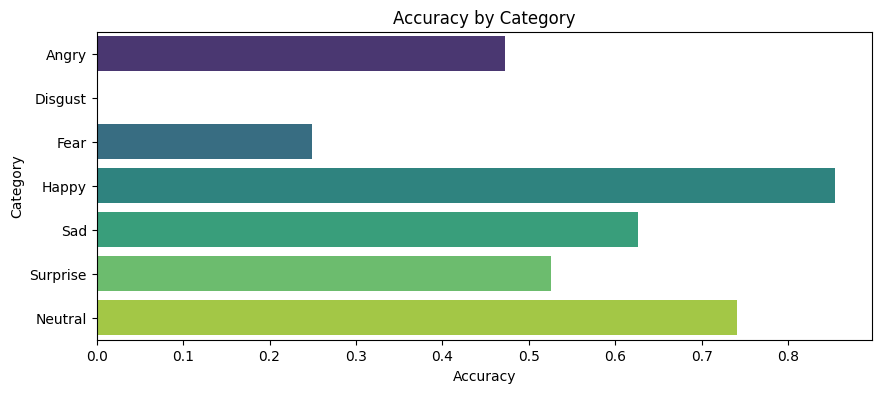

In [ ]:
import matplotlib.pyplot as plt

def calculate_category_accuracies(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    category_accuracies = []
    for i in range(num_classes):
        category_mask = (np.array(true_labels) == i)
        category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
        category_accuracies.append(category_acc)

    return category_accuracies

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

category_accuracies = calculate_category_accuracies(model, test_loader, device, num_classes)

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Category')
ax.set_title('Accuracy by Category')
plt.show()

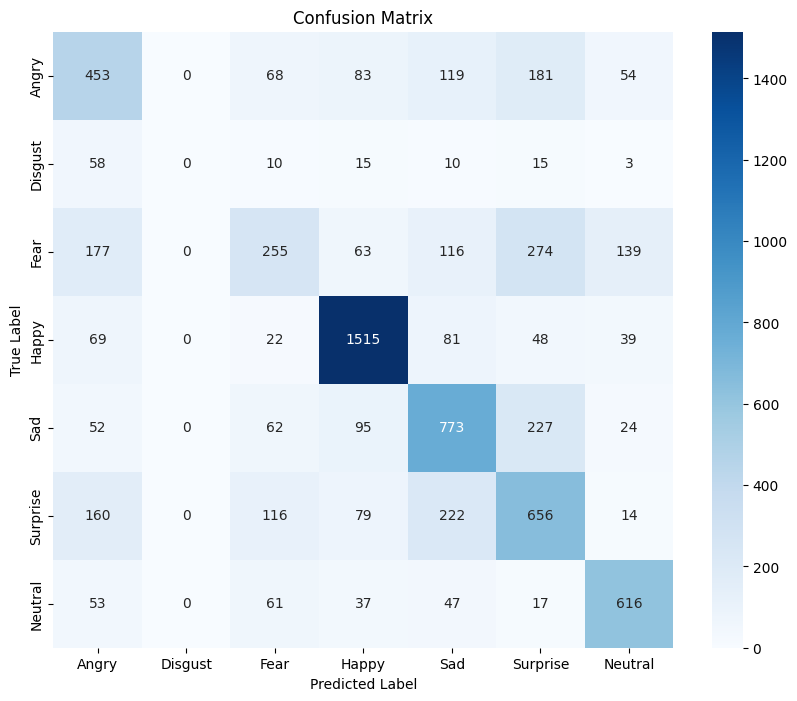

In [ ]:
import seaborn as sns

def plot_confusion_matrix(model, dataloader, device, num_classes, category_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_confusion_matrix(model, test_loader, device, num_classes, category_names)